**TIME SERIES**

El propósito de este notebook es llevar a cabo una predicción de la cantidad de productos únicos (item) vendidos durante las últimas 4 semanas. Con el objetivo de verificar que las predicciones sean acertadas, se utilizarán los datos reales de las últimas 4 semanas disponibles para realizar una comparación gráfica posterior en Power BI.

#**0. IMPORT LIBRARIES & DATASET**

##**0.1 IMPORT LIBRARIES**

In [ ]:
pip install xgboost

In [ ]:
# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


##**0.2 IMPORT DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('C:/Users/paula/OneDrive/Documentos/Nuclio/TFM/gb_union_weeks.csv')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/CSV/creation/Task 1/gb_union_weeks.csv')

In [ ]:
df.head(3)

,year_week,id,quantity,item,category,department,store,store_code,region,sell_price,date
0,20114.0,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,NaN,2011-01-29
1,20114.0,ACCESORIES_1_001_BOS_2,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,NaN,2011-01-29
2,20114.0,ACCESORIES_1_001_BOS_3,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,NaN,2011-01-29


In [ ]:
df.shape

(8354260, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   year_week   float64
 1   id          object 
 2   quantity    int64  
 3   item        object 
 4   category    object 
 5   department  object 
 6   store       object 
 7   store_code  object 
 8   region      object 
 9   sell_price  float64
 10  date        object 
dtypes: float64(2), int64(1), object(8)
memory usage: 701.1+ MB


##**0.3 DATA FORMATTING**

In [ ]:
# convertir la fecha en formato date
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [ ]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2011-01-29 00:00:00
Max date is 2016-04-18 00:00:00


In [ ]:
# Eliminamos los datos de 2011 por estar incompletos y de 2012 por tener un pico de crecimiento que podría afectar a la predicción
df = df[df['date'] >= '2013-01-01']

In [ ]:
df.isnull().sum()

year_week           0
id                  0
quantity            0
item                0
category            0
department          0
store               0
store_code          0
region              0
sell_price    1434691
date                0
dtype: int64

In [ ]:
# ordenamos los valores
df.sort_values(["item", "date"], ascending = True, inplace = True)
df.tail(30)

,year_week,id,quantity,item,category,department,store,store_code,region,sell_price,date
8293270,201614.0,SUPERMARKET_3_827_BOS_1,17,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,South_End,BOS_1,Boston,1.2,2016-04-04
8293271,201614.0,SUPERMARKET_3_827_BOS_2,0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Roxbury,BOS_2,Boston,1.2,2016-04-04
8293272,201614.0,SUPERMARKET_3_827_BOS_3,3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Back_Bay,BOS_3,Boston,1.2,2016-04-04
8293273,201614.0,SUPERMARKET_3_827_NYC_1,36,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,1.2,2016-04-04
8293274,201614.0,SUPERMARKET_3_827_NYC_2,25,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Harlem,NYC_2,New York,1.2,2016-04-04
8293275,201614.0,SUPERMARKET_3_827_NYC_3,43,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,1.2,2016-04-04
8293276,201614.0,SUPERMARKET_3_827_NYC_4,7,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,1.2,2016-04-04
8293277,201614.0,SUPERMARKET_3_827_PHI_1,36,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,1.2,2016-04-04
8293278,201614.0,SUPERMARKET_3_827_PHI_2,22,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,1.2,2016-04-04
8293279,201614.0,SUPERMARKET_3_827_PHI_3,8,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,1.2,2016-04-04


In [ ]:
# imputación de precios a los valores nulos
df["sell_price"] = df.groupby("id", group_keys = False)["sell_price"].apply(
    lambda series: series.backfill().ffill()
)

Como la columna de " quantity" es la que se va a predecir, debemos eliminar los datos que tenemos de esta, para impurle 0, ya que sino, el modelo aprendería de ellos y no daría una correcta ejecución.

In [ ]:
# Establecer valores nulos en las columnas 'quantity'
# para las semanas especificadas
weeks = [201613.0, 201614.0, 201615.0, 201616.0]
df.loc[df['year_week'].isin(weeks), ['quantity']] = np.nan

In [ ]:
df["quantity"].fillna(0, inplace = True)

In [ ]:
df.tail()

,year_week,id,quantity,item,category,department,store,store_code,region,sell_price,date
8354255,201616.0,SUPERMARKET_3_827_NYC_3,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,1.2,2016-04-18
8354256,201616.0,SUPERMARKET_3_827_NYC_4,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,1.2,2016-04-18
8354257,201616.0,SUPERMARKET_3_827_PHI_1,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,1.2,2016-04-18
8354258,201616.0,SUPERMARKET_3_827_PHI_2,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,1.2,2016-04-18
8354259,201616.0,SUPERMARKET_3_827_PHI_3,0.0,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,1.2,2016-04-18


#**1.EDA**

##**1.1 EDA: GLOBAL**

Se visualizan cómo se distribuyen los datos a lo largo del tiempo, además de unos gráficos de autocorrelación (utilizados en ARIMA) para ver el impacto que podrían tener los lags en el modelo-

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [ ]:
y = df.set_index("date").resample("W")["quantity"].sum()[:-4] # quitamos los registros de las últimas 4 semanas

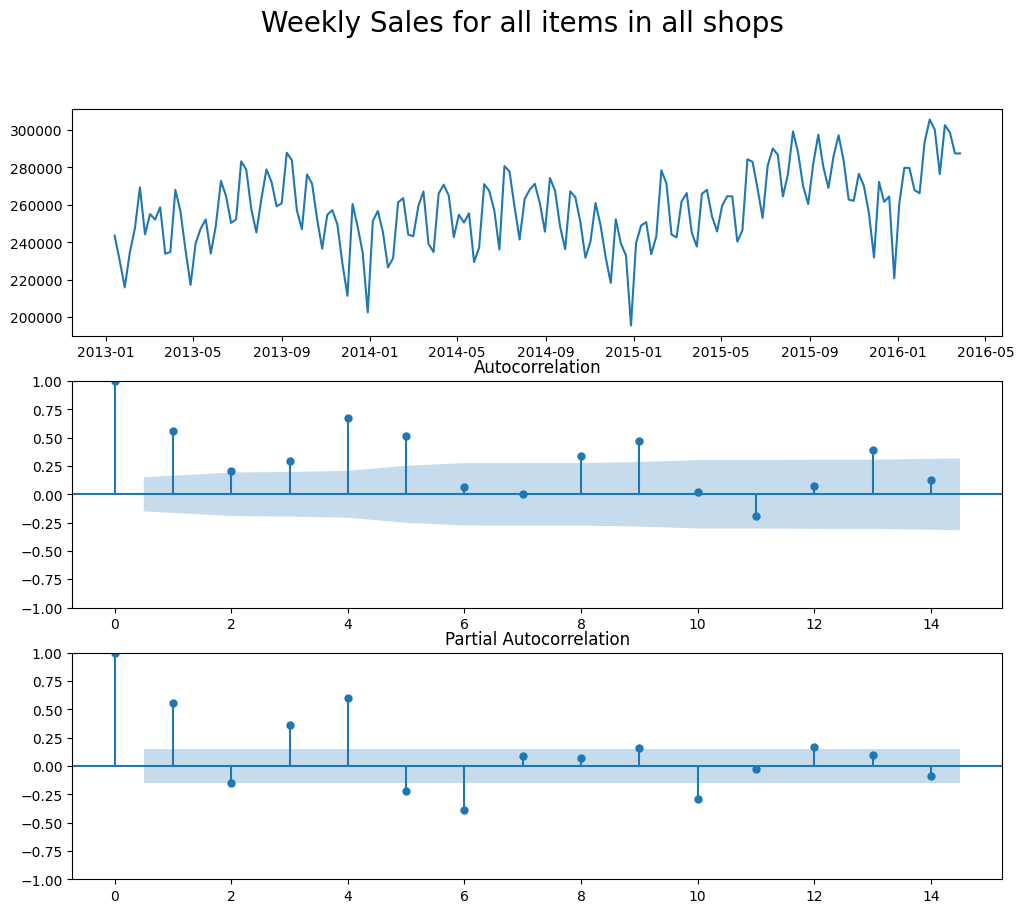

In [ ]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

##**1.2 EDA: FEATURES**

Se visualizan diferentes columnas que podrían ser importantes en el entrenamiento del modelo

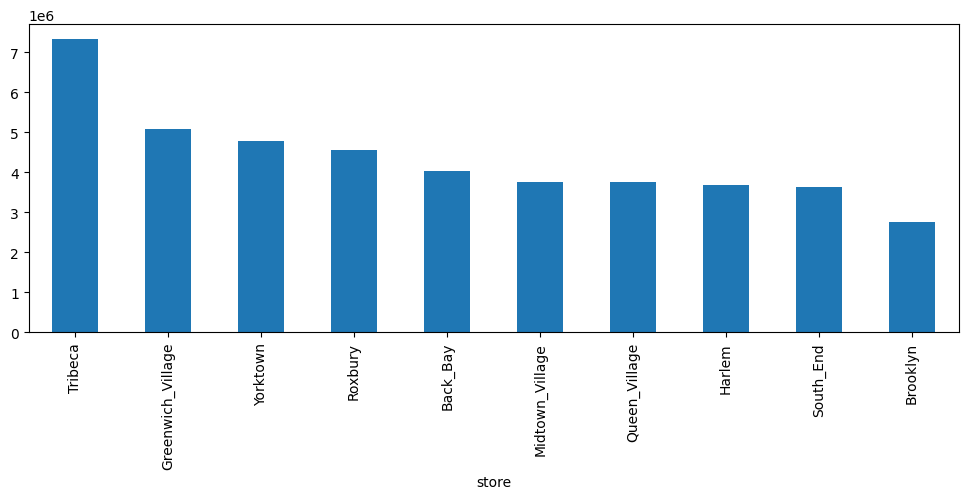

In [ ]:
(
    df.
    groupby(["store"])
    ["quantity"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

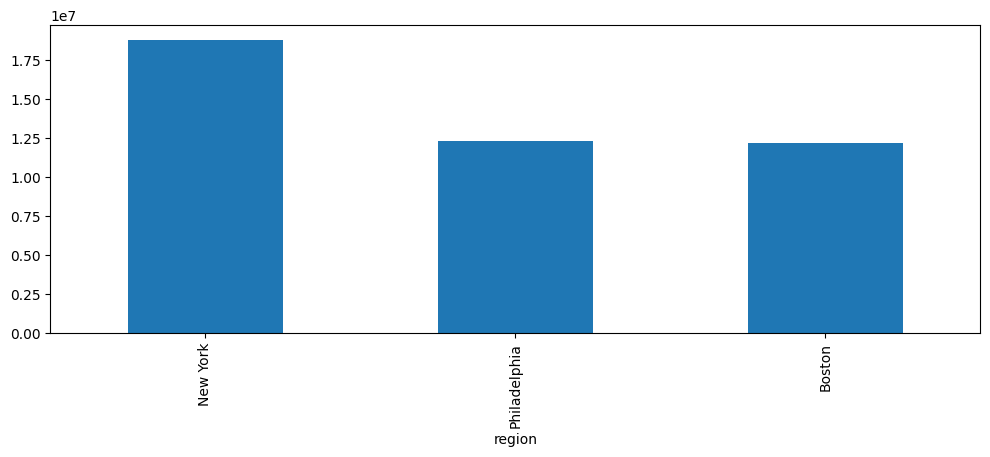

In [ ]:
(
    df.
    groupby(["region"])
    ["quantity"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

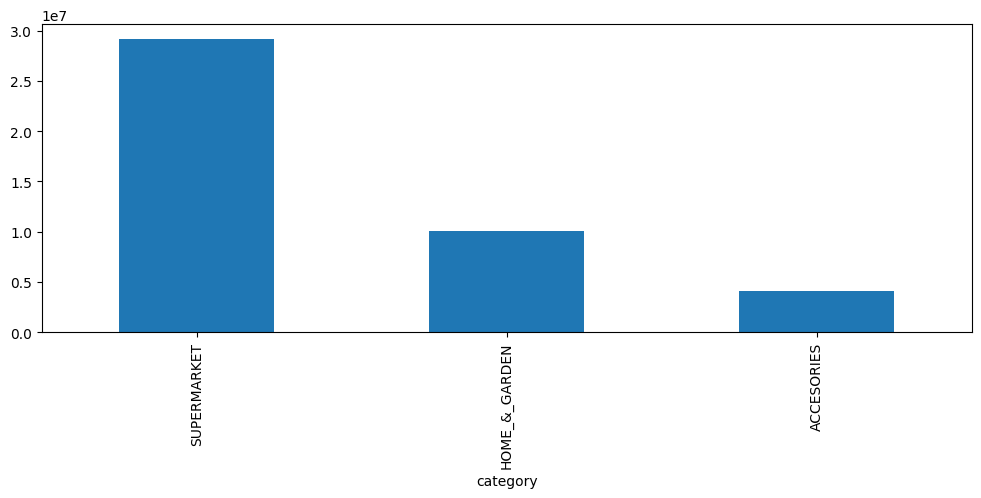

In [ ]:
(
    df.
    groupby(["category"])
    ["quantity"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

#**2. FEATURE ENGINEERING**




##**2.1 FEATURE ENCODING**


Como XGBoost, el algoritmo que se usará para entenar la serie temporal multivariante no acepta valores de tipo categórico se ha creado una regla de código (los valores numéricos escogidos han sido al azar):

- Category: accesories = 12, home_&_garden = 13, supermarket = 14
- Region: Boston = 21, New York = 31, Philadelphia = 41
- Store: South_End = 1, Roxbury = 2, Back_Bay = 3, Greenwich_Village = 4, Harlem = 5, Tribeca = 6, Brooklyn = 7, Midtown_Village = 8, Yorktown = 9, Queen_Village = 10.

El resto de columnas han procesados a partir de concatenar estos códigos.

In [ ]:
df.head()

,year_week,id,quantity,item,category,department,store,store_code,region,sell_price,date
487840,20132.0,ACCESORIES_1_001_BOS_1,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,12.7414,2013-01-07
487841,20132.0,ACCESORIES_1_001_BOS_2,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,12.7414,2013-01-07
487842,20132.0,ACCESORIES_1_001_BOS_3,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,11.4646,2013-01-07
487843,20132.0,ACCESORIES_1_001_NYC_1,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,12.7414,2013-01-07
487844,20132.0,ACCESORIES_1_001_NYC_2,0.0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,10.9858,2013-01-07


In [ ]:
df['category'].unique()

array(['ACCESORIES', 'HOME_&_GARDEN', 'SUPERMARKET'], dtype=object)

In [ ]:
category_map = {
    'ACCESORIES': 12,
    'HOME_&_GARDEN': 13,
    'SUPERMARKET': 14
}

df['category'] = df['category'].map(category_map)

In [ ]:
df['department'].unique()

array(['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1',
       'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2',
       'SUPERMARKET_3'], dtype=object)

In [ ]:
import re

def replace_department(value):
    # Encuentra la parte numérica del valor
    number_part = re.search(r'\d+', value).group()

    # Reemplaza la parte textual por el número correspondiente
    if 'ACCESORIES' in value:
        return f'12{number_part}'
    elif 'HOME_&_GARDEN' in value:
        return f'13{number_part}'
    elif 'SUPERMARKET' in value:
        return f'14{number_part}'
    else:
        return value  # Retorna el valor original si no coincide con ninguna categoría

# Aplica la función a la columna 'department'
df['department'] = df['department'].apply(replace_department)

In [ ]:
df['department'] = df['department'].astype('int64')

In [ ]:
df['item'].unique()

array(['ACCESORIES_1_001', 'ACCESORIES_1_002', 'ACCESORIES_1_003', ...,
       'SUPERMARKET_3_825', 'SUPERMARKET_3_826', 'SUPERMARKET_3_827'],
      dtype=object)

In [ ]:
def replace_item(value):
    # Extrae las partes del valor
    parts = re.match(r'(ACCESORIES|HOME_&_GARDEN|SUPERMARKET)_(\d+)_(\d+)', value)
    if parts:
        category, group, number = parts.groups()

        # Asigna un nuevo número basado en la categoría
        if category == 'ACCESORIES':
            category_number = '12'
        elif category == 'HOME_&_GARDEN':
            category_number = '13'
        elif category == 'SUPERMARKET':
            category_number = '14'

        # Construye el nuevo valor
        return f'{category_number}_{group}_{number}'

# Aplica la función a la columna 'item'
df['item'] = df['item'].apply(replace_item)

In [ ]:
df['region'].unique()

array(['Boston', 'New York', 'Philadelphia'], dtype=object)

In [ ]:
region_map = {
    'Boston': 21,
    'New York': 31,
    'Philadelphia': 41
}

df['region'] = df['region'].map(region_map)

In [ ]:
df['store'].unique()

array(['South_End', 'Roxbury', 'Back_Bay', 'Greenwich_Village', 'Harlem',
       'Tribeca', 'Brooklyn', 'Midtown_Village', 'Yorktown',
       'Queen_Village'], dtype=object)

In [ ]:
stores_with_numbers = {'South_End': 1, 'Roxbury': 2, 'Back_Bay': 3, 'Greenwich_Village': 4,
                       'Harlem': 5, 'Tribeca': 6, 'Brooklyn': 7, 'Midtown_Village': 8,
                       'Yorktown': 9, 'Queen_Village': 10}

# Reemplazar los valores en la columna 'store' con los números del diccionario
df['store'] = df['store'].map(stores_with_numbers)

In [ ]:
df['store_code'].unique()

array(['BOS_1', 'BOS_2', 'BOS_3', 'NYC_1', 'NYC_2', 'NYC_3', 'NYC_4',
       'PHI_1', 'PHI_2', 'PHI_3'], dtype=object)

In [ ]:
store_code_mapping = {
    'BOS_1': 211,
    'BOS_2': 212,
    'BOS_3': 213,
    'NYC_1': 314,
    'NYC_2': 315,
    'NYC_3': 316,
    'NYC_4': 317,
    'PHI_1': 418,
    'PHI_2': 419,
    'PHI_3': 4110
}

df['store_code'] = df['store_code'].map(store_code_mapping)

In [ ]:
df.head()

,year_week,id,quantity,item,category,department,store,store_code,region,sell_price,date
487840,20132.0,ACCESORIES_1_001_BOS_1,0.0,12_1_001,12,121,1,211,21,12.7414,2013-01-07
487841,20132.0,ACCESORIES_1_001_BOS_2,0.0,12_1_001,12,121,2,212,21,12.7414,2013-01-07
487842,20132.0,ACCESORIES_1_001_BOS_3,0.0,12_1_001,12,121,3,213,21,11.4646,2013-01-07
487843,20132.0,ACCESORIES_1_001_NYC_1,0.0,12_1_001,12,121,4,314,31,12.7414,2013-01-07
487844,20132.0,ACCESORIES_1_001_NYC_2,0.0,12_1_001,12,121,5,315,31,10.9858,2013-01-07


In [ ]:
df.drop(['id'], axis=1, inplace=True)

In [ ]:
for col in ['date']:
  df['day'] =df[col].dt.day
  df['day_of_week'] = df['date'].dt.dayofweek
  df['month'] = df[col].dt.month
  df['year'] = df[col].dt.year
  df['trim'] = df[col].dt.quarter

In [ ]:
df.head()

,year_week,quantity,item,category,department,store,store_code,region,sell_price,date,day,day_of_week,month,year,trim
487840,20132.0,0.0,12_1_001,12,121,1,211,21,12.7414,2013-01-07,7,0,1,2013,1
487841,20132.0,0.0,12_1_001,12,121,2,212,21,12.7414,2013-01-07,7,0,1,2013,1
487842,20132.0,0.0,12_1_001,12,121,3,213,21,11.4646,2013-01-07,7,0,1,2013,1
487843,20132.0,0.0,12_1_001,12,121,4,314,31,12.7414,2013-01-07,7,0,1,2013,1
487844,20132.0,0.0,12_1_001,12,121,5,315,31,10.9858,2013-01-07,7,0,1,2013,1


##**2.2 NEW FEATURES**

###**2.1.1 MA**

In [ ]:
df['item_store_sp_ma'] = df.groupby(['item','store'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df['item_department_sp_ma'] = df.groupby(['item','department'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df['department_store_sp_ma'] = df.groupby(['department','store'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df["sell_price_ma"] = df.groupby(["item"])["sell_price"].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df['item_region_month_q_ma'] = df.groupby(['item','region','month'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df['item_cat_month_q_ma'] = df.groupby(['category','region','month'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=2).mean())

In [ ]:
df['category_store_sp_ma'] = df.groupby(['category','store'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df['item_department_sp_ma'] = df.groupby(['item','department','month'])['sell_price'].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

###**2.1.2 LAGS**

* **Build Time Series Features - Lag 1**

In [ ]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,lag=1): # RS_ agregar lag
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {target_column : new_name}
        )
    )
    i=1
    while i <= lag:
        gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i))
        i+=1
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    dfst = pd.merge(df, gb_df_, on = ["date"] + gb_list, how = "left")
    return dfst

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)

df=vars_ts_

Dropping columns that might cause target leakage department_sell_price_sum


In [ ]:
GB_LIST = ["category"]
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
df=vars_ts_

Dropping columns that might cause target leakage category_sell_price_sum


In [ ]:

df.head()

,year_week,quantity,item,category,department,store,store_code,region,sell_price,date,...,trim,item_store_sp_ma,item_department_sp_ma,department_store_sp_ma,sell_price_ma,item_region_month_q_ma,item_cat_month_q_ma,category_store_sp_ma,department_sell_price_sum_lag1,category_sell_price_sum_lag1
0,20132.0,0.0,12_1_001,12,121,1,211,21,12.7414,2013-01-07,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20132.0,0.0,12_1_001,12,121,2,212,21,12.7414,2013-01-07,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20132.0,0.0,12_1_001,12,121,3,213,21,11.4646,2013-01-07,...,1,NaN,NaN,NaN,NaN,NaN,12.7414,NaN,NaN,NaN
3,20132.0,0.0,12_1_001,12,121,4,314,31,12.7414,2013-01-07,...,1,NaN,12.3158,NaN,12.3158,NaN,NaN,NaN,NaN,NaN
4,20132.0,0.0,12_1_001,12,121,5,315,31,10.9858,2013-01-07,...,1,NaN,12.3158,NaN,12.3158,NaN,NaN,NaN,NaN,NaN


* **Build Time Series Features - Lag 2**

In [ ]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,lag=2): # RS_ agregar lag
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {target_column : new_name}
        )
    )
    i=2
    while i <= lag:
        gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i))
        i+=1
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    dfst = pd.merge(df, gb_df_, on = ["date"] + gb_list, how = "left")
    return dfst

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
df=vars_ts_

Dropping columns that might cause target leakage department_sell_price_sum


In [ ]:
GB_LIST = ["category"]
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
df=vars_ts_

Dropping columns that might cause target leakage category_sell_price_sum


In [ ]:
df.head()

,year_week,quantity,item,category,department,store,store_code,region,sell_price,date,...,item_department_sp_ma,department_store_sp_ma,sell_price_ma,item_region_month_q_ma,item_cat_month_q_ma,category_store_sp_ma,department_sell_price_sum_lag1,category_sell_price_sum_lag1,department_sell_price_sum_lag2,category_sell_price_sum_lag2
0,20132.0,0.0,12_1_001,12,121,1,211,21,12.7414,2013-01-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20132.0,0.0,12_1_001,12,121,2,212,21,12.7414,2013-01-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20132.0,0.0,12_1_001,12,121,3,213,21,11.4646,2013-01-07,...,NaN,NaN,NaN,NaN,12.7414,NaN,NaN,NaN,NaN,NaN
3,20132.0,0.0,12_1_001,12,121,4,314,31,12.7414,2013-01-07,...,12.3158,NaN,12.3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20132.0,0.0,12_1_001,12,121,5,315,31,10.9858,2013-01-07,...,12.3158,NaN,12.3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **Build Time Series Features - Lag 3**

In [ ]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,lag=3): # RS_ agregar lag
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {target_column : new_name}
        )
    )
    i=3
    while i <= lag:
        gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i))
        i+=1
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    dfst = pd.merge(df, gb_df_, on = ["date"] + gb_list, how = "left")
    return dfst

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
df=vars_ts_

Dropping columns that might cause target leakage department_sell_price_sum


In [ ]:
GB_LIST = ["category"]
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
df=vars_ts_

Dropping columns that might cause target leakage category_sell_price_sum


In [ ]:
df.head()

,year_week,quantity,item,category,department,store,store_code,region,sell_price,date,...,sell_price_ma,item_region_month_q_ma,item_cat_month_q_ma,category_store_sp_ma,department_sell_price_sum_lag1,category_sell_price_sum_lag1,department_sell_price_sum_lag2,category_sell_price_sum_lag2,department_sell_price_sum_lag3,category_sell_price_sum_lag3
0,20132.0,0.0,12_1_001,12,121,1,211,21,12.7414,2013-01-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20132.0,0.0,12_1_001,12,121,2,212,21,12.7414,2013-01-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20132.0,0.0,12_1_001,12,121,3,213,21,11.4646,2013-01-07,...,NaN,NaN,12.7414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20132.0,0.0,12_1_001,12,121,4,314,31,12.7414,2013-01-07,...,12.3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20132.0,0.0,12_1_001,12,121,5,315,31,10.9858,2013-01-07,...,12.3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##**2.3 NEW DF + 4 WEEKS**

In [ ]:
121960/3049

40.0

In [ ]:
df_pred = df[df['year_week']>201612]

In [ ]:
df_pred['year_week'].unique()

array([201613., 201614., 201615., 201616.])

In [ ]:
df_pred['year_week'] = df_pred['year_week']+4

In [ ]:
df_pred['year_week'].unique()

array([201617., 201618., 201619., 201620.])

#**3. SPLIT TRAIN-TEST**

In [ ]:
df.columns.tolist()

['year_week',
 'quantity',
 'item',
 'category',
 'department',
 'store',
 'store_code',
 'region',
 'sell_price',
 'date',
 'day',
 'day_of_week',
 'month',
 'year',
 'trim',
 'item_store_sp_ma',
 'item_department_sp_ma',
 'department_store_sp_ma',
 'sell_price_ma',
 'item_region_month_q_ma',
 'item_cat_month_q_ma',
 'category_store_sp_ma',
 'department_sell_price_sum_lag1',
 'category_sell_price_sum_lag1',
 'department_sell_price_sum_lag2',
 'category_sell_price_sum_lag2',
 'department_sell_price_sum_lag3',
 'category_sell_price_sum_lag3']

In [ ]:
df.set_index("item", inplace = True)

In [ ]:
train_index = sorted(list(df["date"].unique()))[:-8]
valida_index = sorted(list(df["date"].unique()))[-8:-4]
test_index = sorted(list(df["date"].unique()))[-4:]

#NEW
pred_index = test_index

In [ ]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

#NEW
print(f"Our test/prediction index is {pred_index}\n")

Our train index is [Timestamp('2013-01-07 00:00:00'), Timestamp('2013-01-14 00:00:00')] - ... - [Timestamp('2016-02-15 00:00:00'), Timestamp('2016-02-22 00:00:00')]

Our validation index is [Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-07 00:00:00'), Timestamp('2016-03-14 00:00:00'), Timestamp('2016-03-21 00:00:00')]

Our test/prediction index is [Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-04 00:00:00'), Timestamp('2016-04-11 00:00:00'), Timestamp('2016-04-18 00:00:00')]

Our test/prediction index is [Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-04 00:00:00'), Timestamp('2016-04-11 00:00:00'), Timestamp('2016-04-18 00:00:00')]



In [ ]:
X_train = df[df["date"].isin(train_index)].drop(['quantity', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['quantity']

X_valida = df[df["date"].isin(valida_index)].drop(['quantity', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['quantity']

X_test = df[df["date"].isin(test_index)].drop(['quantity', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['quantity']

#NEW
X_pred = df[df["date"].isin(pred_index)].drop(['quantity', "date"], axis = 1)
Y_pred = df[df["date"].isin(pred_index)]['quantity']

#**4. MODEL TRAIN**

In [ ]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)
model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)

[0]	validation_0-rmse:21.58942	validation_1-rmse:20.81587
[1]	validation_0-rmse:20.93247	validation_1-rmse:20.18090
[2]	validation_0-rmse:20.56956	validation_1-rmse:19.87292
[3]	validation_0-rmse:20.35664	validation_1-rmse:19.66574
[4]	validation_0-rmse:20.20617	validation_1-rmse:19.55933
[5]	validation_0-rmse:20.08302	validation_1-rmse:19.43863
[6]	validation_0-rmse:20.01437	validation_1-rmse:19.40691
[7]	validation_0-rmse:19.93176	validation_1-rmse:19.34818
[8]	validation_0-rmse:19.89203	validation_1-rmse:19.31585
[9]	validation_0-rmse:19.84212	validation_1-rmse:19.27998
[10]	validation_0-rmse:19.79731	validation_1-rmse:19.24417
[11]	validation_0-rmse:19.76218	validation_1-rmse:19.20973
[12]	validation_0-rmse:19.73182	validation_1-rmse:19.19711
[13]	validation_0-rmse:19.70464	validation_1-rmse:19.19197
[14]	validation_0-rmse:19.69402	validation_1-rmse:19.18129
[15]	validation_0-rmse:19.66943	validation_1-rmse:19.07067
[16]	validation_0-rmse:19.64175	validation_1-rmse:19.04905
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#**5. PREDICTION**

In [ ]:
if "quantity" in X_test.columns:
    X_test.drop("quantity", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["quantity"] = Y_test_predict

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 18_882
Validation RMSE: 18_452


In [ ]:
## Train RMSE: 18_927    Validation RMSE: 18_725

In [ ]:
(
    X_test[["item", "quantity"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

In [ ]:
X_test

,item,year_week,category,department,store,store_code,region,sell_price,day,day_of_week,...,item_region_month_q_ma,item_cat_month_q_ma,category_store_sp_ma,department_sell_price_sum_lag1,category_sell_price_sum_lag1,department_sell_price_sum_lag2,category_sell_price_sum_lag2,department_sell_price_sum_lag3,category_sell_price_sum_lag3,quantity
0,12_1_001,201613.0,12,121,1,211,21,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,3.415640
1,12_1_001,201613.0,12,121,2,212,21,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,4.354650
2,12_1_001,201613.0,12,121,3,213,21,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,4.397493
3,12_1_001,201613.0,12,121,4,314,31,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,5.224963
4,12_1_001,201613.0,12,121,5,315,31,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,4.418497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121955,14_3_827,201616.0,14,143,6,316,31,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,40.330719
121956,14_3_827,201616.0,14,143,7,317,31,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,13.573589
121957,14_3_827,201616.0,14,143,8,418,41,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,23.632929
121958,14_3_827,201616.0,14,143,9,419,41,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,29.353060


In [ ]:
MIN_DATE = X_test["quantity"].min()
MAX_DATE = X_test["quantity"].max()
print(f"Min sales is {MIN_DATE}\nMax sales is {MAX_DATE}")

Min sales is -13.969106674194336
Max sales is 189.1943359375


In [ ]:
X_test['quantity'] =X_test['quantity'].round(0)

In [ ]:
X_test['quantity'] =X_test['quantity'].astype('int64')

In [ ]:
X_test['quantity'] = np.where(X_test['quantity'] < 0, 0, X_test['quantity'])

In [ ]:
X_test

,item,year_week,category,department,store,store_code,region,sell_price,day,day_of_week,...,item_region_month_q_ma,item_cat_month_q_ma,category_store_sp_ma,department_sell_price_sum_lag1,category_sell_price_sum_lag1,department_sell_price_sum_lag2,category_sell_price_sum_lag2,department_sell_price_sum_lag3,category_sell_price_sum_lag3,quantity
0,12_1_001,201613.0,12,121,1,211,21,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,3
1,12_1_001,201613.0,12,121,2,212,21,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,4
2,12_1_001,201613.0,12,121,3,213,21,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,4
3,12_1_001,201613.0,12,121,4,314,31,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,5
4,12_1_001,201613.0,12,121,5,315,31,10.9858,28,0,...,10.9858,10.9858,10.9858,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121955,14_3_827,201616.0,14,143,6,316,31,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,40
121956,14_3_827,201616.0,14,143,7,317,31,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,14
121957,14_3_827,201616.0,14,143,8,418,41,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,24
121958,14_3_827,201616.0,14,143,9,419,41,1.2000,18,0,...,1.2000,1.2000,1.2000,NaN,NaN,NaN,NaN,NaN,NaN,29


###PREDICTION

In [ ]:
# Paso 1: Obtener las fechas de los próximos 4 períodos
ultima_fecha = X_test.index[-1]  # Última fecha en tus datos de prueba
proximas_fechas = pd.date_range(start=ultima_fecha + pd.DateOffset(days=1), periods=4, freq='D')

# Paso 2: Generar las características necesarias para predecir
# Si no tienes características adicionales, simplemente usa las fechas como entrada
caracteristicas_prediccion = proximas_fechas.values.reshape(-1, 1)

# Paso 3: Predecir con el modelo
prediccion = model.predict(caracteristicas_prediccion)

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'

##**5.1 X_test TRANSFORM**

Se vuelven a cambiar las columnas al formato original

In [ ]:
region_map = {
     21: 'Boston',
     31: 'New York',
     41: 'Philadelphia'
}

X_test['region'] = X_test['region'].map(region_map)

In [ ]:
category_map = {
     12: 'ACCESORIES',
     13: 'HOME_&_GARDEN',
     14: 'SUPERMARKET'
}

X_test['category'] = X_test['category'].map(category_map)

In [ ]:
stores_with_numbers = {
     1: 'South_End',
     2: 'Roxbury',
     3: 'Back_Bay',
     4: 'Greenwich_Village',
     5: 'Harlem',
     6: 'Tribeca',
     7: 'Brooklyn',
     8: 'Midtown_Village',
     9: 'Yorktown',
     10: 'Queen_Village'}


X_test['store'] = X_test['store'].map(stores_with_numbers)

In [ ]:
def replace_item2(value):
    # Extrae las partes del valor
    parts = re.match(r'(12|13|14)_(\d+)_(\d+)', value)
    if parts:
        category, group, number = parts.groups()

        # Asigna un nuevo número basado en la categoría
        if category == '12':
            category_number = 'ACCESORIES'
        elif category == '13':
            category_number = 'HOME_&_GARDEN'
        elif category == '14':
            category_number = 'SUPERMARKET'

        # Construye el nuevo valor
        return f'{category_number}_{group}_{number}'

# Aplica la función a la columna 'item'
X_test['item'] = X_test['item'].apply(replace_item2)

In [ ]:
department_num = {
     121: 'ACCESORIES_1',
     122: 'ACCESORIES_2',
     131: 'HOME_&_GARDEN_1',
     132: 'HOME_&_GARDEN_2',
     141: 'SUPERMARKET_1',
     142: 'SUPERMARKET_2',
     143: 'SUPERMARKET_3'

}
X_test['department'] = X_test['department'].map(department_num)

In [ ]:
X_test

In [ ]:
X_test.to_csv('time_series_xgboost.csv', index=False)